In [72]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import random as rd
from cvxpy import *
from sklearn.utils import shuffle


style.use('ggplot')


class SVM():
    def fit(self):
        #(w, b, success_ratio)
        best_success_ratio = 0
        for w, b, success_ratio in self.results:
            if success_ratio > best_success_ratio:
                best_success_ratio = success_ratio
                self.w = w
                self.b = b
        self.success_ratio = best_success_ratio
            
                
    def cross_validate(self, data):
        self.data = data
        self.split_data = split_data(data)
        n = len(self.split_data)
        results = []
        for i in range(n):
            test = self.split_data[i]
            train = [df for num, df in enumerate(self.split_data) if not num == i]
            train = pd.concat(train)
            test_X = normalize_01(np.array(test.drop(['class'], 1)).astype(np.float))
            test_y = np.array(test['class']).astype(np.float)
            train_X = normalize_01(np.array(train.drop(['class'], 1)).astype(np.float))
            train_y = np.array(train['class']).astype(np.float)
            self.w, self.b = optimize(train_X, train_y)
            succes_ratio = self.test(test_X, test_y)
            results.append((self.w, self.b, succes_ratio))
        self.results = results

    
    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)
    

    def test(self, X, y):
        all_instances = 0
        correct_instances = 0
        for index, instance in enumerate(X):
            all_instances += 1
            if self.predict(instance) == y[index]:
                correct_instances += 1
        success_ratio = correct_instances/all_instances
        return success_ratio
    
    
    def visualize(self):
        if len(self.data.columns) != 3:
            return 'Number of attribute dimensions is not 2'
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1,1,1)
        first_class = df.loc[df['class'] == 1]
        second_class = df.loc[df['class'] == -1]
        fst_att, snd_att, _ = first_class.columns
        self.ax.scatter(first_class[fst_att], first_class[snd_att], color = 'red')
        self.ax.scatter(second_class[fst_att], second_class[snd_att], color = 'blue')
        
        t = np.arange(-0.2, 1.0, 0.01)
        s = - clf.w[0]/clf.w[1] * t - clf.b/clf.w[1]

        s_plus = - clf.w[0]/clf.w[1] * t - (clf.b - 1)/clf.w[1]
        s_minus = - clf.w[0]/clf.w[1] * t - (clf.b + 1)/clf.w[1]
        
        self.ax.plot(t, s, 'black')
        self.ax.plot(t, s_plus, 'r--')
        self.ax.plot(t, s_minus, 'b--')
        
        plt.show()
        
    

        
    
def normalize_01(X):
    X_normed = (X - X.min(0)) / X.ptp(0)
    return X_normed
    
    
    
def optimize(X, y, C=5):

    # train to get w and b for hyperplane
    # solving optimizational problem for min ||w|| + C Sum(e_i)
    # subject to y_i (w^t x_i + b) >= 1 - e_i and e_i >= 0 for i = 1, ... , len data[0]

    n = len(X)
    m = len(X[0])

    w = Variable(m)
    b = Variable(1)
    e = Variable(n)


    obj = Minimize(norm(w) + C * sum_entries(e))

    constraints = [e >= 0]

    for i in range(n):
        constraints.append(1 - e[i]- y[i] * (w.T * X[i] + b) <= 0)

    prob = Problem(obj, constraints)
    prob.solve()

    w = np.squeeze(np.asarray(w.T.value))
    b = b.value        
    return (w, b)
        
        
        

def split_data(data, k=10):
    '''
    :param data:
    :param k:
    :return:
    '''
    data = shuffle(data)
    data.reset_index(drop=True,inplace=True)
    split_data = partition(data, k)
    return split_data
        


def partition(lst, n):
    '''
    :param lst: array of elemnts
    :param n: number of partitions
    :return: array partitioned into n arrays
    '''
    division = len(lst) / n
    return [lst[round(division * i):round(division * (i + 1))] for i in range(n)]







def normalize_df(df):
    df[df.columns.difference(['class'])] = df[df.columns.difference(['class'])].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    


# df = pd.read_csv('breast-cancer-wisconsin.data.txt')
# df.replace('?', -99, inplace=True)
# df.drop(['id'], 1, inplace=True)

# df.loc[df['class'] == 2, 'class'] = 1
# df.loc[df['class'] == 4, 'class'] = -1


# X = df.drop(['class'], 1)
# y = df['class']

#X = np.array(X).astype(np.float)


# clf = SVM()

# clf.cross_validate(df)


df = pd.read_csv('bezdekIris.txt', sep=",", header=None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'clas' ]

df = df[df.clas != 'Iris-versicolor']
df = df.rename(columns={'clas': 'class',})


df.replace({'Iris-setosa': 1, 'Iris-virginica': -1,}, inplace=True)
df.reset_index()


df.drop(['petal_length', 'petal_width'], 1, inplace=True)

X = df.drop(['class'], 1)
y = df['class']

X = np.array(X).astype(np.float)
y = np.array(y).astype(np.float)


clf = SVM()

clf.cross_validate(df)





In [73]:
clf.fit()

In [74]:
clf.w

array([-9. ,  5.5])

In [75]:
clf.b

0.75000000011375145

In [76]:
normalize_df(df)
df[:10]


,sepal_length,sepal_width,class
0,0.222222,0.590909,1
1,0.166667,0.363636,1
2,0.111111,0.454545,1
3,0.083333,0.409091,1
4,0.194444,0.636364,1
5,0.305556,0.772727,1
6,0.083333,0.545455,1
7,0.194444,0.545455,1
8,0.027778,0.318182,1
9,0.166667,0.409091,1


In [77]:
X = normalize_01(X)

uspeli = 0 
vsi = 0
for i in range(len(X)):
    vsi += 1
    if clf.predict(X[i]) == y[i]:
        uspeli += 1
uspeli / vsi

0.99

In [78]:
clf.success_ratio

1.0

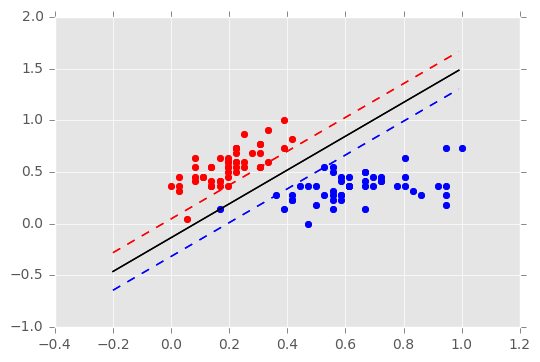

In [79]:

first_class = df.loc[df['class'] == 1]
second_class = df.loc[df['class'] == -1]

plt.scatter(first_class['sepal_length'], first_class['sepal_width'], color = 'red')
plt.scatter(second_class['sepal_length'], second_class['sepal_width'], color = 'blue')



t = np.arange(-0.2, 1.0, 0.01)
s = - clf.w[0]/clf.w[1] * t - clf.b/clf.w[1]


s_plus = - clf.w[0]/clf.w[1] * t - (clf.b - 1)/clf.w[1]
s_minus = - clf.w[0]/clf.w[1] * t - (clf.b + 1)/clf.w[1]

# x1 = 0
# x2 = 1.2
# y1 = - clf.w[0]/clf.w[1] * x1 - clf.b/clf.w[1]
# y2 = - clf.w[0]/clf.w[1] * x2 - clf.b/clf.w[1]
#plt.plot(x1, y1, x2, y2,'o')

plt.plot(t, s, 'black')
plt.plot(t, s_plus, 'r--')
plt.plot(t, s_minus, 'b--')

plt.show()

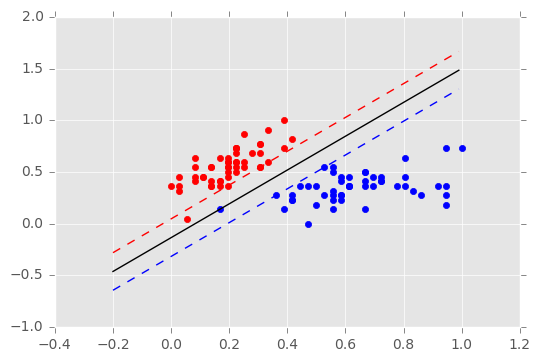

In [82]:
clf.visualize()